In [31]:
!ls -a

.  ..  .empty  .ipynb_checkpoints  catboost_info  context_data	mts-cup.ipynb


In [32]:
!ls context_data/competition_data_final_pqt -a

.
..
_SUCCESS
part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet
part-00001-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet
part-00002-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet
part-00003-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet
part-00004-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet
part-00005-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet
part-00006-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet
part-00007-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet
part-00008-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet
part-00009-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet


In [33]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [34]:
%pip install scikit-learn -q
%pip install catboost -q
%pip install implicit -q
%pip install scipy -q
%pip install pyarrow -q
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import scipy
import implicit
import bisect
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import sklearn.metrics as m
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [35]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit_2.pqt'

In [36]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()
id_to_submit.head()

,user_id
221301,221301
31271,31271
211594,211594
253119,253119
192578,192578


In [37]:
data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet')
pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

,field,type
0,region_name,string
1,city_name,string
2,cpe_manufacturer_name,string
3,cpe_model_name,string
4,url_host,string
5,cpe_type_cd,string
6,cpe_model_os_type,string
7,price,double
8,date,date32[day]
9,part_of_day,string


Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

In [38]:
data.select(['cpe_type_cd']).to_pandas()['cpe_type_cd'].value_counts()

smartphone    32630468
plain             3995
tablet            3204
phablet           1042
Name: cpe_type_cd, dtype: int64

In [39]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [40]:
%%time
data_agg = data.select(['user_id', 'url_host', 'request_cnt']).\
    group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")])

CPU times: user 5.21 s, sys: 533 ms, total: 5.75 s
Wall time: 5.8 s


In [41]:
url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

77904 urls
41594 users


In [42]:
%%time
#%conda uninstall faiss-cpu -q
#%pip install faiss-cpu --no-cache -q
values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict))
cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = 50, iterations = 30, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

CPU times: user 2.48 s, sys: 1.14 s, total: 3.62 s
Wall time: 5.58 s


In [43]:

%%time
'''
%pip install ipywidgets jupyter -q
%jupyter nbextension enable --py widgetsnbextension -q
%pip uninstall jupyter-console 
%pip install jupyter-console
'''
from ipywidgets import FloatProgress
als.fit(mat, show_progress=False)
u_factors = als.model.user_factors 
d_factors = als.model.item_factors

CPU times: user 2min 3s, sys: 1min 11s, total: 3min 14s
Wall time: 32.7 s


## Получим оценку по полу

In [44]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 521 ms, sys: 0 ns, total: 521 ms
Wall time: 534 ms


1    13538
0    13058
Name: is_male, dtype: int64

In [45]:
%%time
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], test_size = 0.33, random_state = SPLIT_SEED)
clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')

GINI по полу 0.628
CPU times: user 57.2 s, sys: 10.8 s, total: 1min 7s
Wall time: 9.59 s


In [50]:
#clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], verbose = False)
predict = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'inner', on = ['user_id']))[:,1]
id_to_submit['is_male'] = predict

ValueError: Length of values (14368) does not match length of index (144724)

## Получим оценку по возрасту

In [52]:
%pip install seaborn -q
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

Note: you may need to restart the kernel to use updated packages.


In [53]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

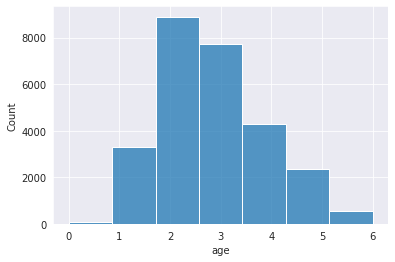

In [54]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], test_size = 0.33, random_state = SPLIT_SEED)

clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(m.classification_report(y_test, clf.predict(x_test), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00        35
       18-25       0.42      0.22      0.29      1106
       25-34       0.44      0.60      0.51      2928
       35-44       0.37      0.46      0.41      2572
       45-54       0.31      0.19      0.24      1375
       55-65       0.39      0.18      0.25       760
         65+       0.25      0.01      0.01       192

    accuracy                           0.40      8968
   macro avg       0.31      0.24      0.24      8968
weighted avg       0.39      0.40      0.38      8968



In [56]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], verbose = False)
id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'inner', on = ['user_id']))

ValueError: Length of values (14368) does not match length of index (144724)

## Сабмит

In [57]:
id_to_submit.head()

,user_id
221301,221301
31271,31271
211594,211594
253119,253119
192578,192578


In [58]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission.csv', index = False)

In [59]:
! head $LOCAL_DATA_PATH/submission.csv

user_id
221301
31271
211594
253119
192578
268458
205507
341343
282144


# Скор на лидерборде

In [60]:
context_scorer(submission, answers)

NameError: name 'context_scorer' is not defined